# LAB 4: NN3: Implementation of gradient moment and normalization 
Implement two improvements to gradient learning of a neural network:
* moment,
* RMSProp gradient normalization.

Compare the rate of convergence of the learning process for both variants.

Conduct experiments on sets of(in parentheses the value of MSE to get 2 points):
* square-large (MSE: 1),
* steps-large (MSE: 3),
* multimodal-large (MSE: 9).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import permutation
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from scipy.special import expit
from sklearn.preprocessing import MinMaxScaler
np.random.seed(777)

## MLP

In [2]:
def sigmoid(x): 
    return expit(x)

def linear(x):
    return x

def sigmoid_prime(z):
    return sigmoid(z) * (1 - sigmoid(z))

def linear_prime(z):
    return z

In [3]:
def generate_weights_and_biases(layers, init_method):
    weights = []
    biases = []
    if init_method == 'uniform':
        for i in range(1, len(layers)):
            np.random.seed(123)
            weights.append(np.random.uniform(low=0.0, high=1.0, size=(layers[i-1], layers[i])))
            biases.append(np.zeros((1, layers[i])))
    elif init_method == 'Xavier':
        for i in range(1, len(layers)):
            np.random.seed(123)
            weights.append(np.random.randn(layers[i-1], layers[i]) * np.sqrt(1/layers[i-1]))
            biases.append(np.random.randn(1, layers[i])*np.sqrt(1/(layers[i-1])))
    elif init_method == 'He':
        for i in range(1, len(layers)):
            np.random.seed(777)
            weights.append(np.random.randn(layers[i-1], layers[i]) * np.sqrt(2/layers[i-1]))
            biases.append(np.random.randn(1, layers[i])*np.sqrt(2/(layers[i-1])))
                          
    return weights, biases

In [4]:
def feedforward(x, weights, biases, layers):   
    activations = [x]
    zs = []
    for j in range(len(layers)-2):
        z = np.dot(activations[-1], weights[j]) + biases[j]
        zs.append(z)
        activation = sigmoid(z)   
        activations.append(activation)
        
    z = np.dot(activations[-1], weights[-1]) + biases[-1]
    zs.append(z)
    activation = linear(z)
    activations.append(activation)
    return activations, zs

In [5]:
def backpropagation(y, activations, weights, biases, zs):
    deltas = [None] * len(weights)
    deltas[-1] = activations[-1] - y
    for i in reversed(range(len(deltas) - 1)):
        deltas[i] = ((weights[i + 1] @ deltas[i + 1].T) * sigmoid_prime(zs[i]).T).T

    biases_prime = [None] * len(deltas)
    weights_prime = [None] * len(deltas)
    y_size = y.shape[0]
    for i in range(len(deltas)):
        weights_prime[i] = np.dot(deltas[i].T, activations[i]).T / y_size
        biases_prime[i] = np.dot(deltas[i].T, np.ones((y_size, 1))).T / y_size
        
    return weights_prime, biases_prime

In [6]:
def calculate_loss(y, activations, losses, do_scaling, scaler_y=None):
    if do_scaling:
        loss = mean_squared_error(scaler_y.inverse_transform(y), scaler_y.inverse_transform(activations[-1]))
    else:
        loss = mean_squared_error(y, activations[-1])
    losses.append(loss)
    return losses

In [7]:
def update_weights_biases(weights, biases, learning_rate, weights_prime, biases_prime, method, lambda_moment=None, momentum_w=None, momentum_b=None, beta_rms=None, grad_sq_w=None, grad_sq_b=None):

    for i in range(len(weights)):

            if method == 'SGD':
                weights[i] -= learning_rate * weights_prime[i]
                biases[i] -= learning_rate * biases_prime[i]
                
            elif method == 'momentum':
                momentum_w[i] = weights_prime[i] + lambda_moment * momentum_w[i]
                weights[i] -= learning_rate * momentum_w[i]
                momentum_b[i] = biases_prime[i] + lambda_moment * momentum_b[i]
                biases[i] -= learning_rate * momentum_b[i]

            elif method == 'RMSProp':
                grad_sq_w[i] = beta_rms*grad_sq_w[i] + (1-beta_rms)*weights_prime[i]**2
                weights[i] -= learning_rate * (weights_prime[i] / np.sqrt(grad_sq_w[i]))
                grad_sq_b[i] = beta_rms*grad_sq_b[i] + (1-beta_rms)*biases_prime[i]**2
                biases[i] -= learning_rate * (biases_prime[i] / np.sqrt(grad_sq_b[i])) 
                
    return weights, biases

In [8]:
def scale_data(x, y, x_test, y_test):
    
    scaler_x = MinMaxScaler()
    scaler_x.fit(x)
    x = pd.DataFrame(scaler_x.transform(x))
    x_test = pd.DataFrame(scaler_x.transform(x_test))

    scaler_y= MinMaxScaler()
    scaler_y.fit(y)
    y = pd.DataFrame(scaler_y.transform(y))
    y_test = pd.DataFrame(scaler_y.transform(y_test))

    return x, y, x_test, y_test, scaler_y, scaler_x

### implementation of learning with moment and RMSProp gradient normalization

In [9]:
def train(x, y, x_test, y_test, layers, epochs, learning_rate, init_method, method, batch_size=None, do_scaling=False, scaler_y=None, lambda_moment = None, beta_rms = None):
    
    weights, biases = generate_weights_and_biases(layers, init_method)
    losses = [] 

    momentum_w = [np.zeros(w.shape) for w in weights]
    momentum_b = [np.zeros(b.shape) for b in biases]
    grad_sq_w = [np.zeros(w.shape) for w in weights]
    grad_sq_b = [np.zeros(b.shape) for b in biases]

    for epoch in range(epochs):
        p = np.random.permutation(len(y))
        x = x.iloc[p]
        y = y.iloc[p]
        
        if batch_size != None:
            j = 0
            while j < len(y):
                x_batch = x[j:j + batch_size]
                y_batch = y[j:j + batch_size]
                j = j + batch_size
                activations_batch, zs = feedforward(x_batch, weights, biases, layers)
                weights_prime, biases_prime = backpropagation(y_batch, activations_batch, weights, biases, zs)
                weights, biases = update_weights_biases(weights, biases, learning_rate, weights_prime, biases_prime, method, lambda_moment, momentum_w, momentum_b, beta_rms, grad_sq_w, grad_sq_b)   
            
            activations, zs = feedforward(x, weights, biases, layers)
            losses = calculate_loss(y, activations, losses, do_scaling, scaler_y)

        else:
            activations, zs = feedforward(x, weights, biases, layers)
            losses = calculate_loss(y, activations, losses, do_scaling, scaler_y)
            weights_prime, biases_prime = backpropagation(y, activations, weights, biases, zs)
            weights, biases = update_weights_biases(weights, biases, learning_rate, weights_prime, biases_prime, method, lambda_moment, momentum_w, momentum_b, beta_rms, grad_sq_w, grad_sq_b)            
        

        if epoch % 500 == 0:
            activations_test, zs_test = feedforward(x_test, weights, biases, layers)
            if do_scaling:
                loss_test = mean_squared_error(scaler_y.inverse_transform(y_test), scaler_y.inverse_transform(activations_test[-1]))
            else:
                loss_test = mean_squared_error(y_test, activations_test[-1])
            print("Epoch {}: Loss train: {} Loss test: {}".format(epoch, losses[-1], loss_test))

    return weights, biases, losses

In [10]:
def evaluate(x, y, x_test, y_test, layers, epochs, learning_rate, init_method, method, batch_size = None, do_scaling=False, lambda_moment=None, beta_rms=None):
    
    scaler_y = None
    scaler_x = None
    if do_scaling:
       x, y, x_test, y_test, scaler_y, scaler_x = scale_data(x, y, x_test, y_test)
    
    weights, biases, losses = train(x, y, x_test, y_test, layers, epochs, learning_rate, init_method, method, batch_size, do_scaling, scaler_y, lambda_moment, beta_rms)
       
    activations, zs = feedforward(x, weights, biases, layers)
    activations_test, zs = feedforward(x_test, weights, biases, layers)

    if do_scaling:
        predictions = scaler_y.inverse_transform(activations[-1]) 
        predictions_test = scaler_y.inverse_transform(activations_test[-1]) 
        y = scaler_y.inverse_transform(y)
        y_test = scaler_y.inverse_transform(y_test)
        x = scaler_x.inverse_transform(x)
        x_test = scaler_x.inverse_transform(x_test)
    else:
        predictions = activations[-1]
        predictions_test = activations_test[-1]
    
    print("MSE na zbiorze testowym:", mean_squared_error(y_test, predictions_test))
    
    plt.subplots(1, 2, figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(x, y, color='green')
    plt.scatter(x, predictions, color='red')
    plt.title("Zbiór treningowy")
    plt.subplot(1, 2, 2)
    plt.scatter(x_test, y_test, color='green')
    plt.scatter(x_test, predictions_test, color='red')
    plt.title("Zbiór testowy")
    plt.show()
    return losses, predictions, predictions_test

## square-large

In [11]:
data_train = pd.read_csv('../data/regression/square-large-training.csv', index_col = 0)
data_test = pd.read_csv('../data/regression/square-large-test.csv', index_col = 0)
x = data_train[['x']]
y = data_train[['y']]
x_test = data_test[['x']]
y_test = data_test[['y']]

na całym zbiorze

Epoch 0: Loss train: 7340.616451200224 Loss test: 11515.45701932975
Epoch 500: Loss train: 48.1942746616867 Loss test: 329.71602854942824
Epoch 1000: Loss train: 33.765350219930205 Loss test: 246.53170491042383
Epoch 1500: Loss train: 23.206789379450857 Loss test: 170.53878999450802
Epoch 2000: Loss train: 17.823251794741147 Loss test: 123.01965022183184
Epoch 2500: Loss train: 13.181528655882156 Loss test: 95.48147491025463
Epoch 3000: Loss train: 10.258235384372172 Loss test: 75.67273971952022
Epoch 3500: Loss train: 8.919040591587638 Loss test: 55.480374647599746
Epoch 4000: Loss train: 6.595829132606991 Loss test: 46.1688866530623
Epoch 4500: Loss train: 5.786968752739065 Loss test: 38.69665273240571
MSE na zbiorze testowym: 29.002825780139357


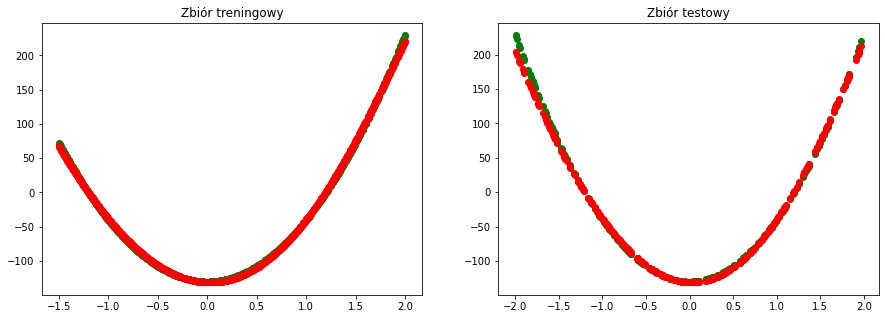

In [13]:
losses, predictions, predictions_test = evaluate(x, y, x_test, y_test, layers=[1, 4, 1], epochs=5000, learning_rate=0.025, init_method='He', method='momentum', batch_size=20, do_scaling=True, lambda_moment = 0.9)

batch version

Epoch 0: Loss train: 7954.985177861066 Loss test: 11995.351950259925
Epoch 500: Loss train: 11.531854359713922 Loss test: 84.73356618888802
Epoch 1000: Loss train: 3.148070696626203 Loss test: 20.152635119157253
Epoch 1500: Loss train: 1.226982616488113 Loss test: 4.998640329795839
Epoch 2000: Loss train: 0.6306214718503034 Loss test: 1.2101402881584102
Epoch 2500: Loss train: 0.4309808098811217 Loss test: 0.5248157244789121
MSE na zbiorze testowym: 0.29588497859063734


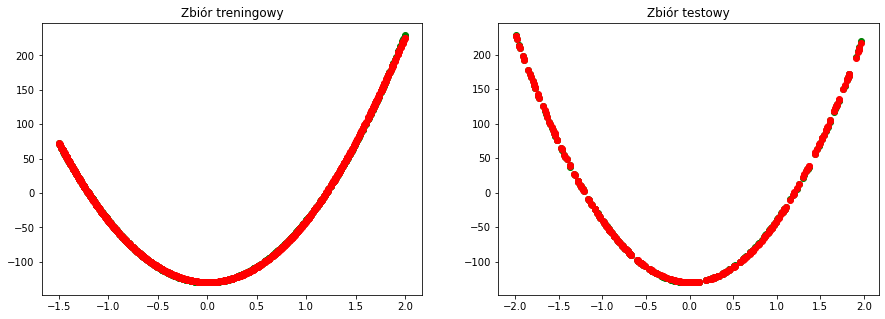

In [14]:
losses, predictions, predictions_test = evaluate(x, y, x_test, y_test, layers=[1, 4, 1], epochs=3000, learning_rate=0.091, init_method='uniform', method='momentum', batch_size=20, do_scaling=True, lambda_moment = 0.88)

Epoch 0: Loss train: 30585.442093708367 Loss test: 29125.880457706924
Epoch 500: Loss train: 81.90985914157727 Loss test: 349.2581526020375
Epoch 1000: Loss train: 51.546549230993044 Loss test: 273.7072442274096
Epoch 1500: Loss train: 39.75801692965814 Loss test: 193.4393845570011
Epoch 2000: Loss train: 24.14069679318517 Loss test: 114.9346976359427
Epoch 2500: Loss train: 22.099244186697454 Loss test: 71.30421595518463
MSE na zbiorze testowym: 45.786233386289844


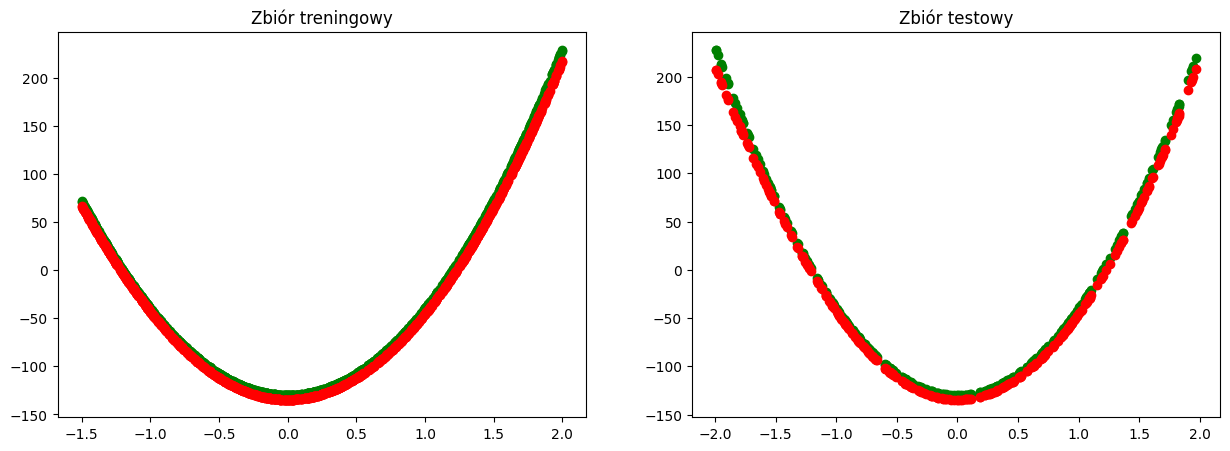

In [82]:
losses, predictions, predictions_test = evaluate(x, y, x_test, y_test, layers=[1, 5, 1], epochs=3000, learning_rate=0.01, init_method='uniform', method='RMSProp', batch_size=64, do_scaling=True, beta_rms = 0.95)

#### convergence plots

In [92]:
epochs = [50, 100, 200, 500, 1000, 2000, 3000, 4000, 5000]

results_momentum_test = []
results_rms_test = []
results_sgd_test = []
results_momentum_train = []
results_rms_train = []
results_sgd_train = []

for epoch in epochs:
    losses_momentum, predictions_m, predictions_test_m = evaluate(x, y, x_test, y_test, layers=[1, 5, 1], epochs=epoch, learning_rate=0.09, init_method='uniform', method='momentum', batch_size=16, do_scaling=True, lambda_moment=0.9)
    losses_rms, predictions_r, predictions_test_r = evaluate(x, y, x_test, y_test, layers=[1, 5, 1], epochs=epoch, learning_rate=0.009, init_method='uniform', method='RMSProp', batch_size=64, do_scaling=True, beta_rms=0.95)
    losses_sgd, predictions_s, predictions_test_s = evaluate(x, y, x_test, y_test, layers=[1, 5, 1], epochs=epoch, learning_rate=0.09, init_method='uniform', method='SGD', batch_size=32, do_scaling=True)
    
    results_momentum_test.append(mean_squared_error(y_test, predictions_test_m))
    results_rms_test.append(mean_squared_error(y_test, predictions_test_r))
    results_sgd_test.append(mean_squared_error(y_test, predictions_test_s))

    results_momentum_train.append(mean_squared_error(y, predictions_m))
    results_rms_train.append(mean_squared_error(y, predictions_r))
    results_sgd_train.append(mean_squared_error(y, predictions_s))

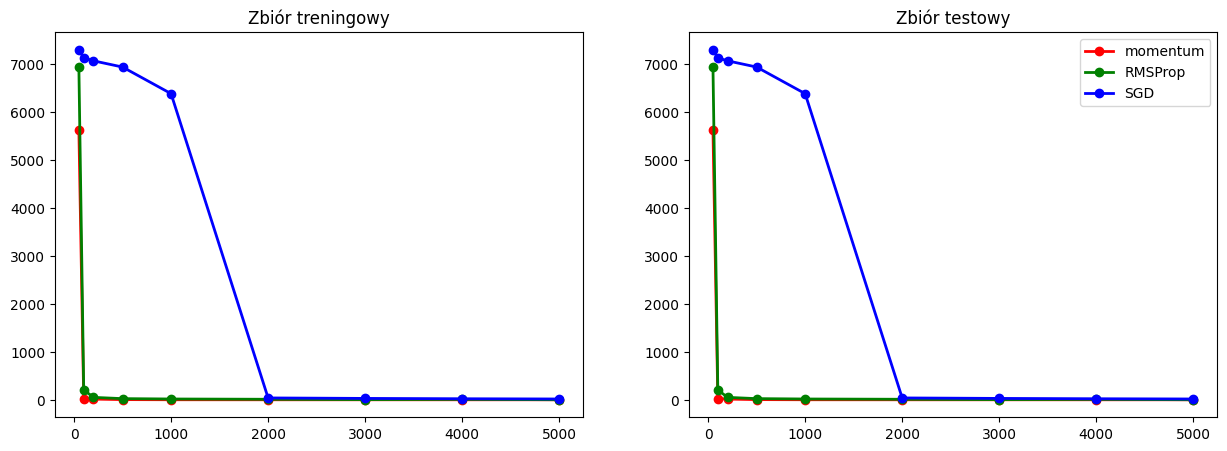

In [93]:
plt.subplots(1, 2, figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, results_momentum_train, color='red', marker='o', linewidth=2, label='momentum')
plt.plot(epochs, results_rms_train, color='green', marker='o', linewidth=2, label='RMSProp')
plt.plot(epochs, results_sgd_train, color='blue', marker='o', linewidth=2, label='SGD')
plt.title("Zbiór treningowy")
plt.subplot(1, 2, 2)
plt.plot(epochs, results_momentum_train, color='red', marker='o', linewidth=2, label='momentum')
plt.plot(epochs, results_rms_train, color='green', marker='o', linewidth=2, label='RMSProp')
plt.plot(epochs, results_sgd_train, color='blue', marker='o', linewidth=2, label='SGD')
plt.title("Zbiór testowy")
plt.legend()
plt.show()

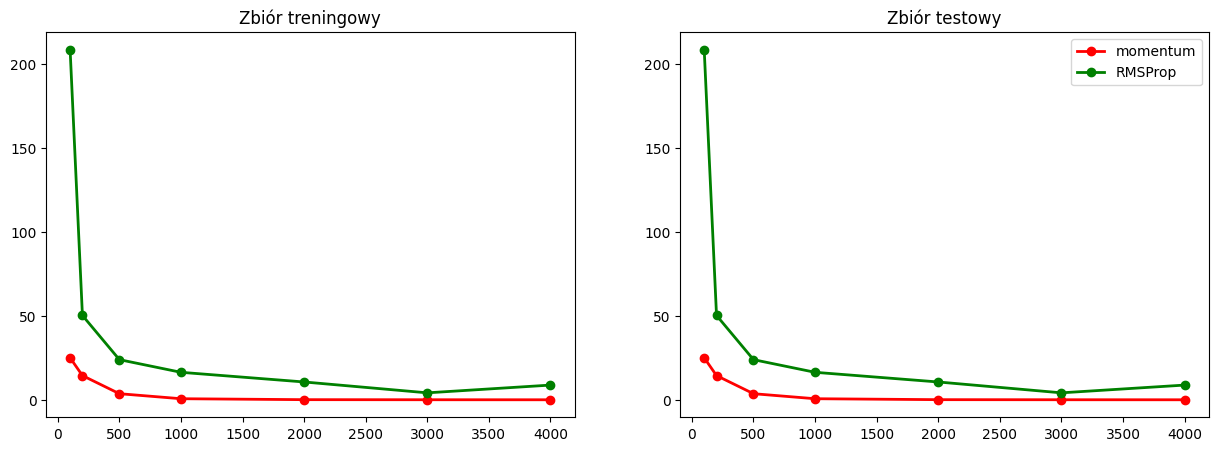

In [97]:
plt.subplots(1, 2, figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs[1:8], results_momentum_train[1:8], color='red', marker='o', linewidth=2, label='momentum')
plt.plot(epochs[1:8], results_rms_train[1:8], color='green', marker='o', linewidth=2, label='RMSProp')
# plt.plot(epochs, results_sgd_train, color='blue', marker='o', linewidth=2, label='SGD')
plt.title("Zbiór treningowy")
plt.subplot(1, 2, 2)
plt.plot(epochs[1:8], results_momentum_train[1:8], color='red', marker='o', linewidth=2, label='momentum')
plt.plot(epochs[1:8], results_rms_train[1:8], color='green', marker='o', linewidth=2, label='RMSProp')
# plt.plot(epochs, results_sgd_train, color='blue', marker='o', linewidth=2, label='SGD')
plt.title("Zbiór testowy")
plt.legend()
plt.show()

## steps large

In [42]:
data_train = pd.read_csv('../data/regression/steps-large-training.csv', index_col = 0)
data_test = pd.read_csv('../data/regression/steps-large-test.csv', index_col = 0)
x = data_train[['x']]
y = data_train[['y']]
x_test = data_test[['x']]
y_test = data_test[['y']]

Epoch 0: Loss train: 7198.663791513008 Loss test: 4179.785370921857
Epoch 500: Loss train: 1.9251180452381749 Loss test: 1.7514321552207384
MSE na zbiorze testowym: 1.7768670419756067


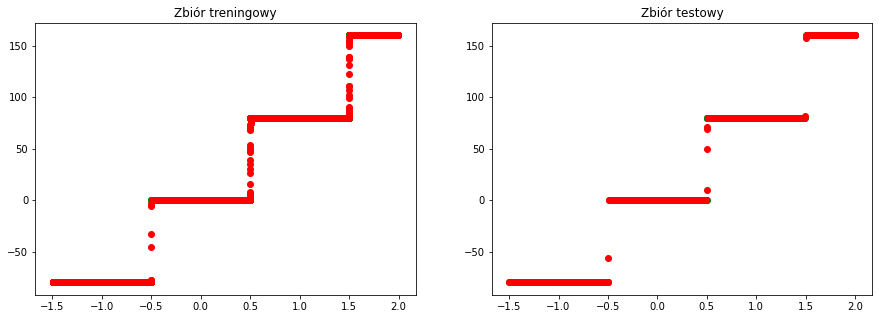

In [43]:
losses = evaluate(x, y, x_test, y_test, layers=[1, 20, 1], epochs=1000, learning_rate=0.4, init_method='He', method='momentum', lambda_moment = 0.97)

Epoch 0: Loss train: 1209.7274867848255 Loss test: 1208.850796206355
Epoch 500: Loss train: 25.983260512464568 Loss test: 21.605831163265492
Epoch 1000: Loss train: 22.46954293253606 Loss test: 23.853584745094743
Epoch 1500: Loss train: 18.25898391772561 Loss test: 13.359021089980942
Epoch 2000: Loss train: 16.545198251652973 Loss test: 13.153718644449299
Epoch 2500: Loss train: 18.17882992556755 Loss test: 10.759248846580867
MSE na zbiorze testowym: 12.973291231070347


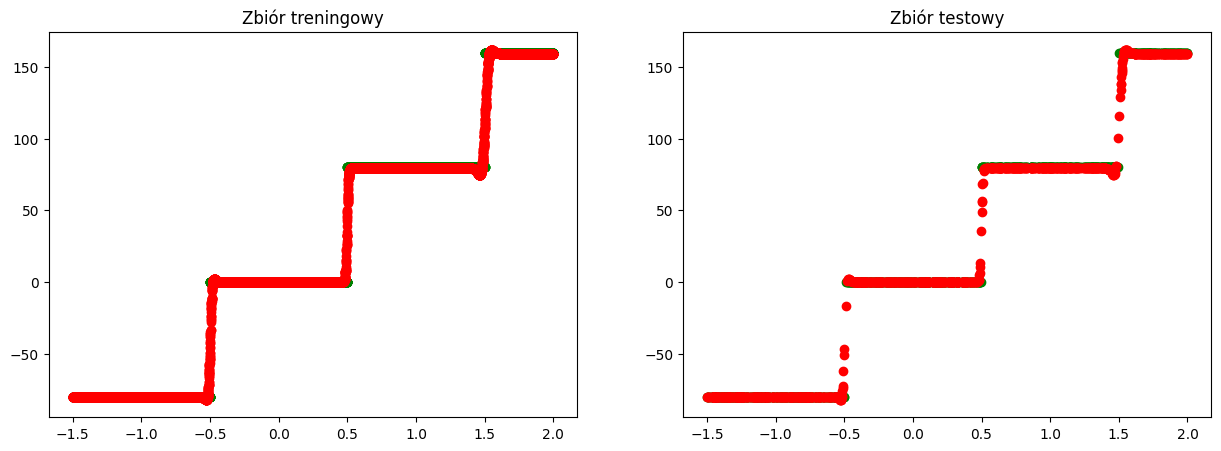

In [86]:
losses, predictions, predictions_test = evaluate(x, y, x_test, y_test, layers=[1, 20, 1], epochs=3000, learning_rate=0.05, init_method='uniform', method='RMSProp', batch_size=16, beta_rms = 0.8)

#### convergence plots

In [101]:
epochs = [25, 50, 100, 200, 500, 1000]

results_momentum_test = []
results_rms_test = []
results_sgd_test = []
results_momentum_train = []
results_rms_train = []
results_sgd_train = []

for epoch in epochs:
    losses_momentum, predictions_m, predictions_test_m = evaluate(x, y, x_test, y_test, layers=[1, 20, 1], epochs=epoch, learning_rate=0.4, init_method='He', method='momentum', lambda_moment = 0.97)
    losses_rms, predictions_r, predictions_test_r = evaluate(x, y, x_test, y_test, layers=[1, 20, 1], epochs=epoch, learning_rate=0.05, init_method='uniform', method='RMSProp', batch_size=16, beta_rms = 0.8)
    losses_sgd, predictions_s, predictions_test_s = evaluate(x, y, x_test, y_test, layers=[1, 20, 1], epochs=epoch, learning_rate=0.01, init_method='uniform', method='SGD', batch_size=20)
    
    results_momentum_test.append(mean_squared_error(y_test, predictions_test_m))
    results_rms_test.append(mean_squared_error(y_test, predictions_test_r))
    results_sgd_test.append(mean_squared_error(y_test, predictions_test_s))

    results_momentum_train.append(mean_squared_error(y, predictions_m))
    results_rms_train.append(mean_squared_error(y, predictions_r))
    results_sgd_train.append(mean_squared_error(y, predictions_s))

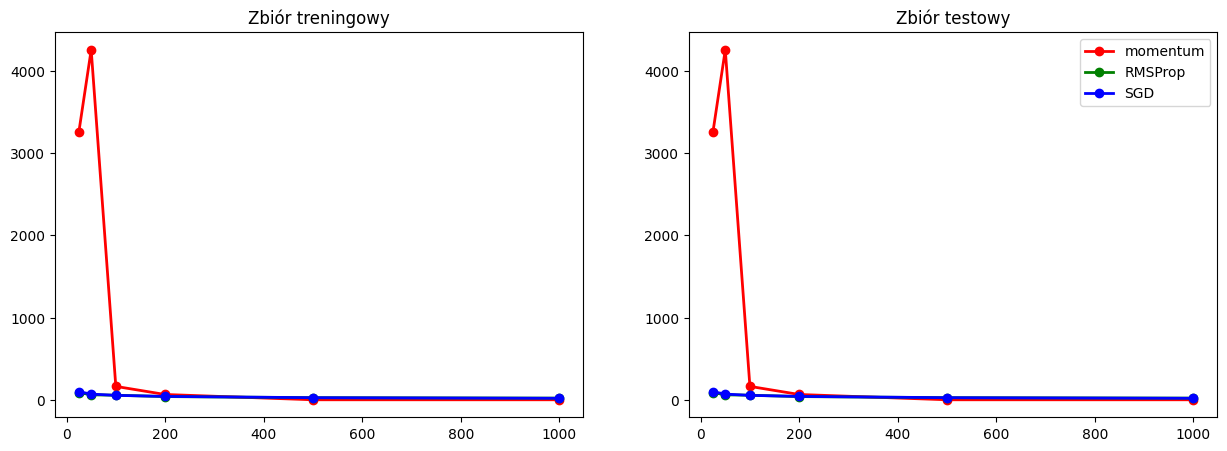

In [104]:
plt.subplots(1, 2, figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, results_momentum_train, color='red', marker='o', linewidth=2, label='momentum')
plt.plot(epochs, results_rms_train, color='green', marker='o', linewidth=2, label='RMSProp')
plt.plot(epochs, results_sgd_train, color='blue', marker='o', linewidth=2, label='SGD')
plt.title("Zbiór treningowy")
plt.subplot(1, 2, 2)
plt.plot(epochs, results_momentum_train, color='red', marker='o', linewidth=2, label='momentum')
plt.plot(epochs, results_rms_train, color='green', marker='o', linewidth=2, label='RMSProp')
plt.plot(epochs, results_sgd_train, color='blue', marker='o', linewidth=2, label='SGD')
plt.title("Zbiór testowy")
plt.legend()
plt.show()

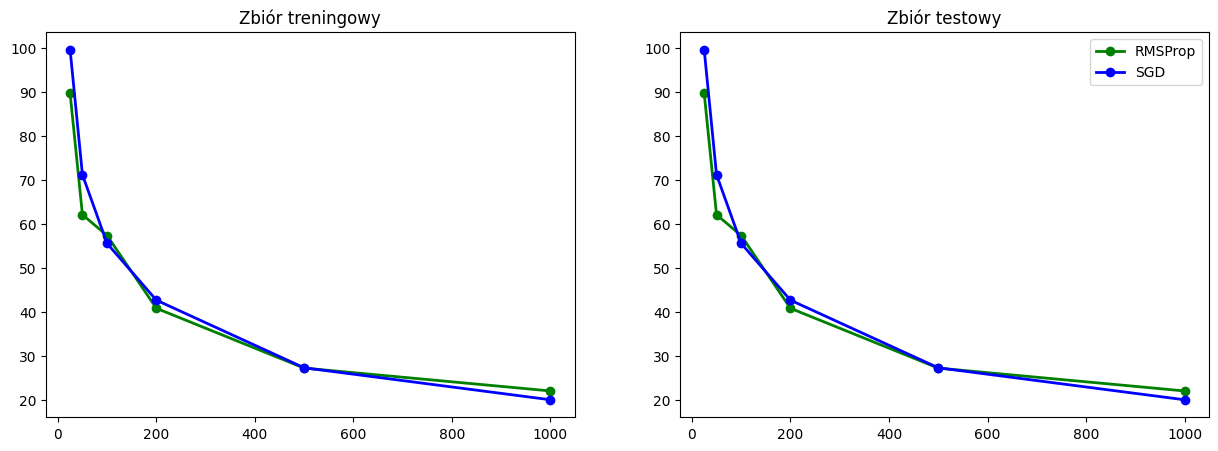

In [105]:
plt.subplots(1, 2, figsize=(15, 5))
plt.subplot(1, 2, 1)
#plt.plot(epochs, results_momentum_train, color='red', marker='o', linewidth=2, label='momentum')
plt.plot(epochs, results_rms_train, color='green', marker='o', linewidth=2, label='RMSProp')
plt.plot(epochs, results_sgd_train, color='blue', marker='o', linewidth=2, label='SGD')
plt.title("Zbiór treningowy")
plt.subplot(1, 2, 2)
#plt.plot(epochs, results_momentum_train, color='red', marker='o', linewidth=2, label='momentum')
plt.plot(epochs, results_rms_train, color='green', marker='o', linewidth=2, label='RMSProp')
plt.plot(epochs, results_sgd_train, color='blue', marker='o', linewidth=2, label='SGD')
plt.title("Zbiór testowy")
plt.legend()
plt.show()

## multimodal large

In [111]:
data_train = pd.read_csv('../data/regression/multimodal-large-training.csv')
data_test = pd.read_csv('../data/regression/multimodal-large-test.csv')
x = data_train[['x']]
y = data_train[['y']]
x_test = data_test[['x']]
y_test = data_test[['y']]

MSE na zbiorze testowym: 3.1154515344029186


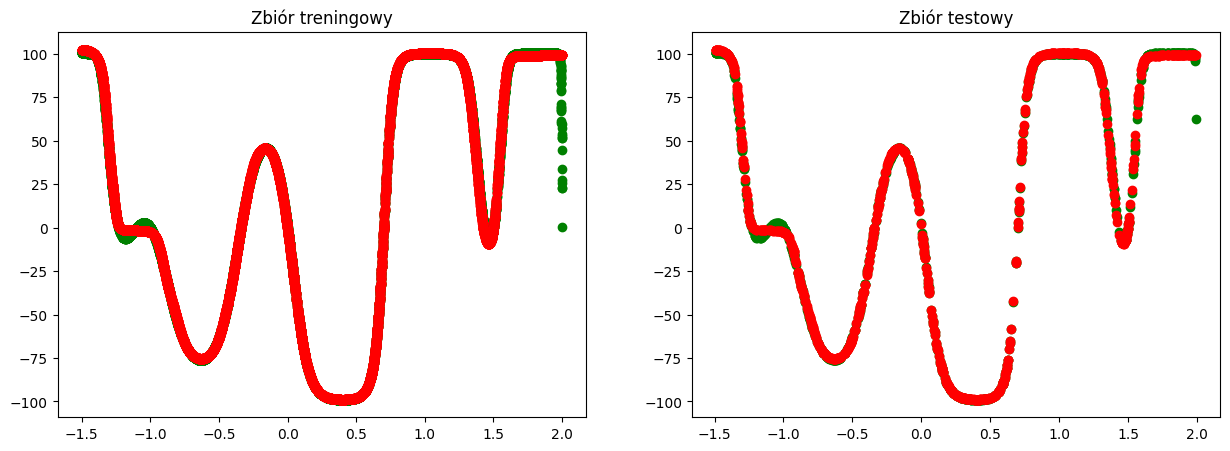

In [63]:
losses = evaluate(x, y, x_test, y_test, layers=[1, 16, 66, 1], epochs=200, learning_rate=0.01, batch_size=128, init_method='Xavier', method='momentum', lambda_moment=0.7)

MSE na zbiorze testowym: 9.504142260685693


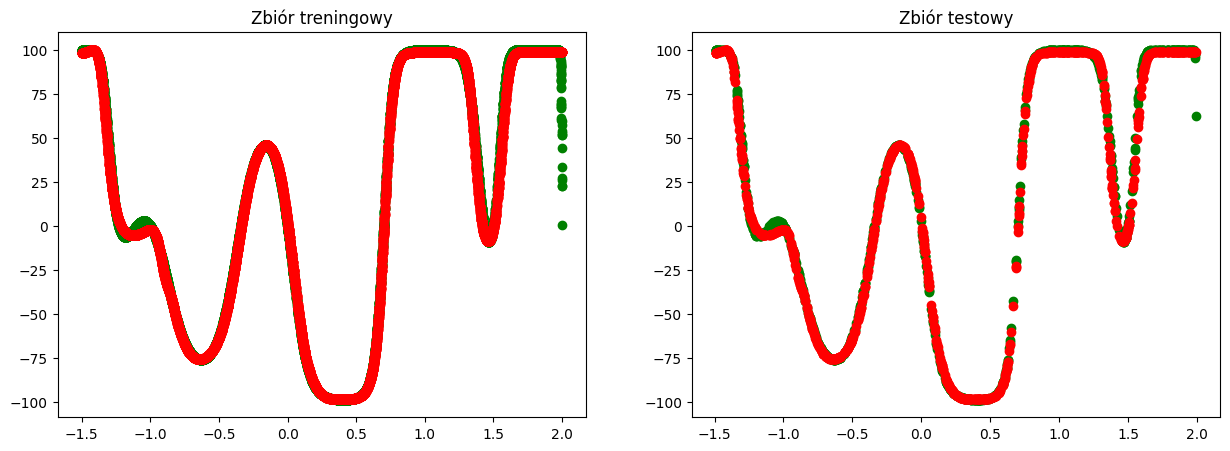

In [119]:
losses = evaluate(x, y, x_test, y_test, layers=[1, 16, 66, 1], epochs=200, learning_rate=0.02, batch_size=32, init_method='uniform', method='RMSProp', beta_rms=0.88)

#### convergence plots

In [125]:
epochs = [25, 50, 75, 100, 200]

results_momentum_test = []
results_rms_test = []
results_sgd_test = []
results_momentum_train = []
results_rms_train = []
results_sgd_train = []

for epoch in epochs:
    losses_momentum, predictions_m, predictions_test_m = evaluate(x, y, x_test, y_test, layers=[1, 16, 66, 1], epochs=epoch, learning_rate=0.01, batch_size=128, init_method='Xavier', method='momentum', lambda_moment=0.7)
    losses_rms, predictions_r, predictions_test_r = evaluate(x, y, x_test, y_test, layers=[1, 16, 66, 1], epochs=epoch, learning_rate=0.02, batch_size=32, init_method='uniform', method='RMSProp', beta_rms=0.88)
    losses_sgd, predictions_s, predictions_test_s = evaluate(x, y, x_test, y_test, layers=[1, 16, 66, 1], epochs=epoch, learning_rate=0.01, batch_size=100, init_method='He', method='SGD')
    
    results_momentum_test.append(mean_squared_error(y_test, predictions_test_m))
    results_rms_test.append(mean_squared_error(y_test, predictions_test_r))
    results_sgd_test.append(mean_squared_error(y_test, predictions_test_s))

    results_momentum_train.append(mean_squared_error(y, predictions_m))
    results_rms_train.append(mean_squared_error(y, predictions_r))
    results_sgd_train.append(mean_squared_error(y, predictions_s))

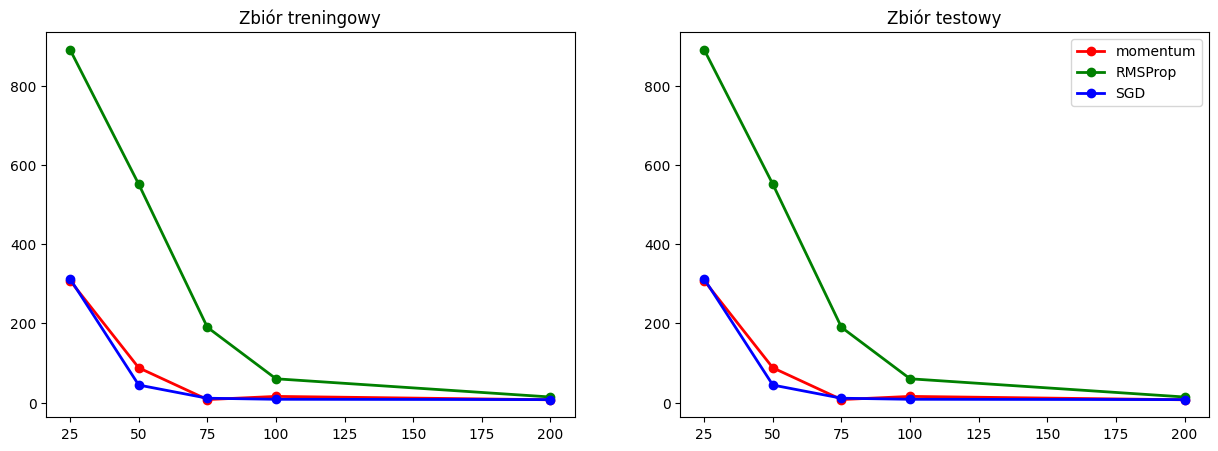

In [126]:
plt.subplots(1, 2, figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, results_momentum_train, color='red', marker='o', linewidth=2, label='momentum')
plt.plot(epochs, results_rms_train, color='green', marker='o', linewidth=2, label='RMSProp')
plt.plot(epochs, results_sgd_train, color='blue', marker='o', linewidth=2, label='SGD')
plt.title("Zbiór treningowy")
plt.subplot(1, 2, 2)
plt.plot(epochs, results_momentum_train, color='red', marker='o', linewidth=2, label='momentum')
plt.plot(epochs, results_rms_train, color='green', marker='o', linewidth=2, label='RMSProp')
plt.plot(epochs, results_sgd_train, color='blue', marker='o', linewidth=2, label='SGD')
plt.title("Zbiór testowy")
plt.legend()
plt.show()